# General logic of simulation

In [1]:
import numpy as np, matplotlib.pyplot as plt
import logging
%matplotlib widget

logging.basicConfig(level=logging.INFO)
# file_handler = logging.FileHandler('log_file.log')
# file_handler.setLevel(logging.DEBUG)
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(filename)s - %(message)s')
# file_handler.setFormatter(formatter)

class Square:
    def __init__(self, x1, y1, x2, y2, zone=-1, portals=None, absorb_prob=0):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.portals = portals if portals is not None else {}
        self.absorb_prob = absorb_prob
        self.zone = zone
        self.logger = logging.getLogger(f"Square({x1}, {y1}, {x2}, {y2})")
        self.logger.setLevel(logging.INFO)
        # self.logger.addHandler(file_handler)

    # Add a portal to neighbouring square. 0 - portal on top, 1 - portal on right, 2 - portal on bottom, 3 - portal on left
    def addPortal(self, child, index : int):
        assert index in [0,1,2,3]
        self.portals[index] = child
        mirror_index = (index + 2) % 4
        child.portals[mirror_index] = self

    # All logic regarding particle movement
    # Returns: (active_square, x, y, is_alive)
    def particle_move(self, x0, y0, dx, dy):
        self.logger.debug(f"Got particle {[x0, y0]} with jump {[dx, dy]}")
        # Geometry shortcuts
        x1, x2, y1, y2 = self.x1, self.x2, self.y1, self.y2
        # Movement
        new_x = x0 + dx
        new_y = y0 + dy
        # Is inside?
        if new_x > x1 and new_x < x2 and new_y > y1 and new_y < y2:
            self.logger.debug(f"Particle moved to {[new_x, new_y]}")
            return self, new_x, new_y, True
        # If outside the square, correct to be on boundary
        corr_x, corr_y = new_x, new_y
        if corr_x > x2 or corr_x < x1:
            scale = (x2 - x0) / (corr_x - x0) if corr_x > x2 else (x1 - x0) / (corr_x - x0)
            corr_y = y0 + (corr_y - y0) * scale
            corr_x = x2 if corr_x > x2 else x1
        if corr_y > y2 or corr_y < y1:
            scale = (y2 - y0) / (corr_y - y0) if corr_y > y2 else (y1 - y0) / (corr_y - y0)
            corr_x = x0 + (corr_x - x0) * scale
            corr_y = y2 if corr_y > y2 else y1
        # Check boundary type: 0 - no boundary, 1 - top, 2 - right, 3 - bottom, 4 - left
        boundary = 0 if corr_y == y2 else 1 if corr_x == x2 else 2 if corr_y == y1 else 3 if corr_x == x1 else -1
        assert boundary != -1, f"Something went wrong with boundary detection: Coordinate: {[corr_x, corr_y]}, Square: {self}"
        # Handle the portals
        # Check portal conditions
        if boundary in self.portals:
            portal_required = False
            if boundary % 2  == 0: # top or bottom
                portal_required = (self.portals[boundary].x1 <= corr_x) & (corr_x <= self.portals[boundary].x2)
            else: # left or right
                portal_required = (self.portals[boundary].y1 <= corr_y) & (corr_y <= self.portals[boundary].y2)
            if portal_required:
                self.logger.debug(f"Particle moved to portal {boundary} at {[new_x, new_y]}. Remaining jump: {[dx - corr_x + x0, dy - corr_y + y0]}. Current square: {self}")
                return self.portals[boundary].particle_move(corr_x, corr_y, dx - corr_x + x0, dy - corr_y + y0)
        
        # Either portal not required or portal not exist. Check if absorb
        absorb = np.random.random(1) < self.absorb_prob
        # Kill particle if absorb
        if absorb:
            self.logger.debug(f"Particle absorbed at {[corr_x, corr_y]}")
            return self, corr_x, corr_y, False
        
        # Reflect particle if not absorb
        horizontal_reflection = (boundary == 0) | (boundary == 2)
        self.logger.debug(f"Particle reflected at {[new_x, new_y]}. Remaining jump: {[dx - corr_x + x0, dy - corr_y + y0]}. Horizontal reflection: {horizontal_reflection}")
        if horizontal_reflection:
            return self.particle_move(corr_x, corr_y, dx - corr_x + x0, -(dy - corr_y + y0))
        else:
            return self.particle_move(corr_x, corr_y, -(dx - corr_x + x0), dy - corr_y + y0)

    # Just useful functions to print/plot the square
    def __repr__(self):
        return f'Square({self.x1}, {self.y1}, {self.x2}, {self.y2}, {self.portals.keys()})'
    
    def draw(self, ax, **kwargs):
        ax.vlines(self.x1, self.y1, self.y2, **kwargs)
        ax.vlines(self.x2, self.y1, self.y2, **kwargs)
        ax.hlines(self.y1, self.x1, self.x2, **kwargs)
        ax.hlines(self.y2, self.x1, self.x2, **kwargs)

    def drawAll(self, ax, **kwargs):
        self.draw(ax, **kwargs)
        for portal in self.portals.values():
            portal.draw(ax, **kwargs)

# Create geometry

It works, but it's ugly... 
And I'm lazy to make it better

Total objects:  53


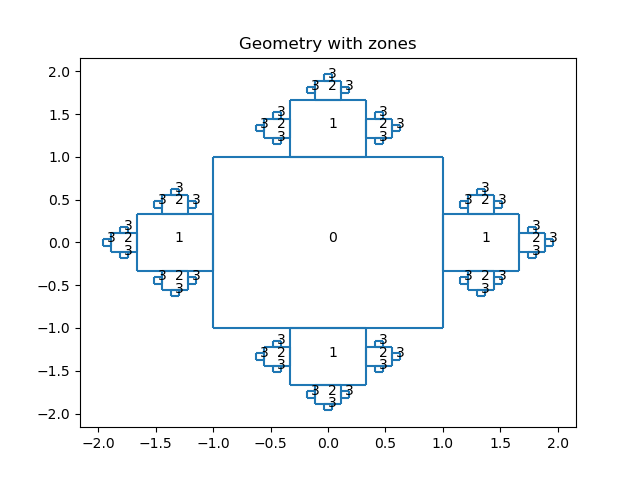

In [2]:
ABSORBTION_PROB = 0.1
FRACTAL_LEVELS = 4
WASTE_A_LOT_OF_TIME_BY_PLOTTING_EVERYTHING = True

def createChild(parent, level = 0):
    if level == FRACTAL_LEVELS: return []
    side = parent.x2 - parent.x1
    objs = []
    for i in range(4):
        if i in parent.portals: continue
        # Top or bottom
        if i % 2 == 0:
            x1 = parent.x1 + side / 3
            x2 = parent.x2 - side / 3
            y1 = parent.y2 if i == 0 else parent.y1 - side / 3
            y2 = parent.y2 + side/3 if i == 0 else parent.y1
        # Left or right
        else:
            x1 = parent.x2 if i == 1 else parent.x1 - side / 3
            x2 = parent.x2 + side/3 if i == 1 else parent.x1
            y1 = parent.y1 + side / 3
            y2 = parent.y2 - side / 3
        newchild = Square(x1, y1, x2, y2, absorb_prob=ABSORBTION_PROB, zone=level)
        parent.addPortal(newchild, i)
        objs += [newchild]
        objs += createChild(newchild, level + 1)
    return objs

root_square = Square(-1, -1, 1, 1, absorb_prob=ABSORBTION_PROB, zone=0)
geom_obj_storage = [root_square] + createChild(root_square, 1)

if WASTE_A_LOT_OF_TIME_BY_PLOTTING_EVERYTHING:
    fig, ax = plt.subplots(1)
    for obj in geom_obj_storage:
        obj.draw(ax)
        ax.text(.5*(obj.x1+obj.x2), .5*(obj.y1+obj.y2), f"{obj.zone}")
    ax.set_title("Geometry with zones")

print("Total objects: ", len(geom_obj_storage))

# Run simulation

In [3]:
from tqdm import tqdm

N_PARTICLES = 1000
STEP = 1 / 3**FRACTAL_LEVELS
N_STEPS = 50000

class WorkerRes:
    def __init__(self, absorbed, iters, death_zone, target_history_x, target_history_y, real_history_x, real_history_y):
        self.absorbed = absorbed
        self.iters = iters
        self.death_zone = death_zone
        self.target_history_x = target_history_x
        self.target_history_y = target_history_y
        self.real_history_x = real_history_x
        self.real_history_y = real_history_y

In [4]:
def myworker(_):
    square = root_square
    x, y = 0, 0
    hist_x, hist_y = [], []
    tar_x, tar_y = [], []
    alive = True
    for i in range(N_STEPS):
        dx, dy = np.random.uniform(- STEP, STEP), np.random.uniform(- STEP, STEP)
        tar_x.append(x + dx)
        tar_y.append(y + dy)
        square, x, y, alive = square.particle_move(x, y, dx, dy)
        hist_x.append(x)
        hist_y.append(y)
        if not alive:
            alive = False
            break
    print("|", end="")
    return WorkerRes(not alive, i, square.zone, tar_x, tar_y, hist_x, hist_y)

In [5]:
import multiprocess as mp
from multiprocess import Pool
print("Number of cpu : ", mp.cpu_count())

pool = Pool(mp.cpu_count() - 2)
results = pool.map(myworker, list(range(N_PARTICLES)))

Number of cpu :  8
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# Plot results

Text(0.5, 1.0, 'Reason of particle death')

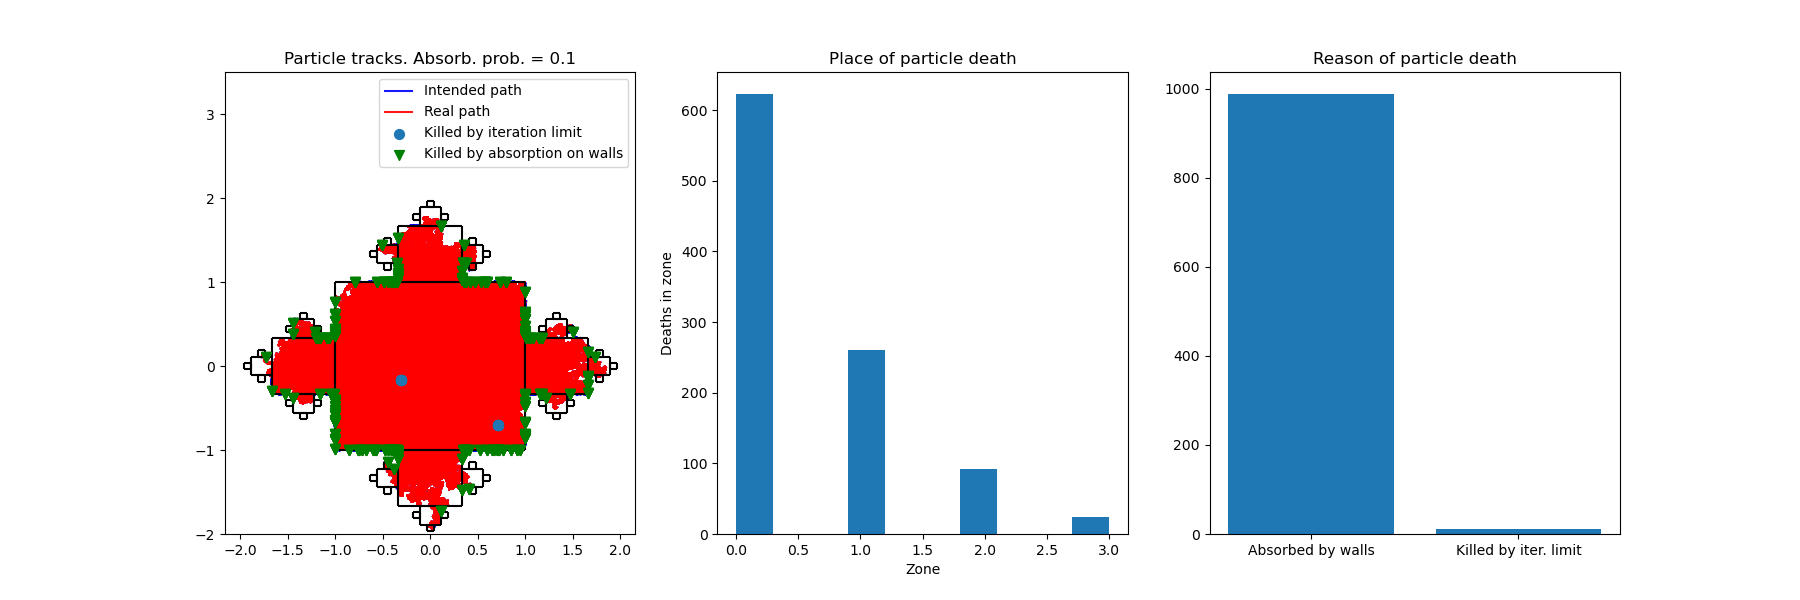

In [12]:
PLOT_PARTICLES = N_PARTICLES

fig, [ax, ax_zone_hist, ax_status_hist] = plt.subplots(1,3, figsize=(18,6))

for i in range(PLOT_PARTICLES):
    data_x = results[i].target_history_x
    data_y = results[i].target_history_y
    ax.plot(data_x, data_y, 'b-', alpha=.9, label="Intended path" if i==0 else None)

for i in range(PLOT_PARTICLES):
    data_x = results[i].real_history_x
    data_y = results[i].real_history_y
    ax.plot(data_x, data_y, 'r-', alpha=.9, label="Real path" if i==0 else None)

ax.scatter([h.real_history_x[-1] for h in results if not h.absorbed]    , [h.real_history_y[-1] for h in results if not h.absorbed]     , s=50, marker='o', zorder=1000, label="Killed by iteration limit")
ax.scatter([h.real_history_x[-1] for h in results if h.absorbed]        , [h.real_history_y[-1] for h in results if h.absorbed]         , s=50, marker='v', zorder=1001, c='green', label="Killed by absorption on walls")

for obj in geom_obj_storage:
    obj.draw(ax, color='black')

ax.legend()
ax.set_ylim(-2.,3.5)
ax.set_title(f"Particle tracks. Absorb. prob. = {ABSORBTION_PROB}")

zone_deaths = np.array([h.death_zone for h in results])
end_alive = np.array([not h.absorbed for h in results])

ax_zone_hist.hist(zone_deaths)
ax_zone_hist.set_xlabel("Zone")
ax_zone_hist.set_ylabel("Deaths in zone")
ax_zone_hist.set_title("Place of particle death")

ax_status_hist.bar(["Absorbed by walls", "Killed by iter. limit"], [sum(end_alive == False), sum(end_alive == True)])
ax_status_hist.set_title("Reason of particle death")
